# Parameter Estimation Workflow for conversion reaction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *
from bayesflow.error_metrics import *
from bayesflow.models import GenerativeModel

In [2]:
%load_ext autoreload
%autoreload 2

## Simulator settings

In [3]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction    
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 11
time_points = np.linspace(0, 10, n_obs)
missing_max = 6


def batch_simulator_augment01(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and augmentation by zeros/ones
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²) 
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0, 0.0])  
        
    return sim_data   


def batch_simulator_insert(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and insert -1
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 1), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²) 
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0])   
        
    return sim_data 


def batch_simulator_timepoints(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and time labels (present time points)
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    n_missing = np.random.randint(0, missing_max+1)
    n_present = n_obs - n_missing
    sim_data = np.empty((n_sim, n_present, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_present observations
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        
        # artificially induce missing data 
        missing_indices = random.sample(range(n_obs), n_missing)
        present_indices = np.setdiff1d(range(n_obs), missing_indices)
        present_timepoints = time_points[present_indices]
        sol = state_2(present_timepoints)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_present)   # observable: y = x_2 + N(0,sigma²)
        sim_data[m, :, 1] = present_timepoints   # time labels
        
    return sim_data 

We build an amortized parameter estimation network.

In [4]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Computational faithfulness

In [5]:
true_params = prior(500) 
x_augment01 = batch_simulator_augment01(true_params, n_obs).astype(np.float32)

In [6]:
# Augment01
summary_net = LSTM(32)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR11_augment01_5ACB_[64,64,64]_LSTM(32)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_samples=1000)
v_augment01 = bootstrap_metrics(np.swapaxes(param_samples_augment01, 0, 1), true_params)
a1 = display_metrics(v_augment01)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_augment01_5ACB_[64,64,64]_LSTM(32)_ckpts\ckpt-300
NRMSE(k_1): 0.026 ± 0.002
NRMSE(k_2): 0.048 ± 0.004
R²(k_1): 0.977 ± 0.004
R²(k_2): 0.927 ± 0.009


In [7]:
# Insert-1
summary_net = LSTM(32)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR11_insert-1_5ACB_[64,64,64]_LSTM(32)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
x_insert = np.ones((500, n_obs, 1), dtype=np.float32)
for m in range(500):
    x_insert[m, :, 0] = x_augment01[m, :, 0]
param_samples_insert = amortizer.sample(x_insert, n_samples=1000)
v_insert = bootstrap_metrics(np.swapaxes(param_samples_insert, 0, 1), true_params)
a2 = display_metrics(v_insert)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_insert-1_5ACB_[64,64,64]_LSTM(32)_ckpts\ckpt-300
NRMSE(k_1): 0.025 ± 0.002
NRMSE(k_2): 0.048 ± 0.004
R²(k_1): 0.978 ± 0.003
R²(k_2): 0.926 ± 0.008


In [8]:
# Timepoints
summary_net = LSTM(32)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
trainer = ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR11_timepoints_5ACB_[64,64,64]_LSTM(32)_ckpts', skip_checks=True)
# BayesFlow samples from the learned posterior
param_samples_timepoints = np.empty((500, 1000, 2), dtype=np.float32)
for m in range(500):
    x = x_augment01[m, :, 1]
    present_indices = np.where(x == 1.)[0]
    x_timepoints = np.empty((1, len(present_indices), 2), dtype=np.float32)
    x_timepoints[0, :, 0] = x_augment01[m, present_indices, 0]
    x_timepoints[0, :, 1] = time_points[present_indices]
    param_samples_timepoints[m] = amortizer.sample(x_timepoints, n_samples=1000)
v_timepoints = bootstrap_metrics(np.swapaxes(param_samples_timepoints, 0, 1), true_params)
a3 = display_metrics(v_timepoints)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR11_timepoints_5ACB_[64,64,64]_LSTM(32)_ckpts\ckpt-300
NRMSE(k_1): 0.025 ± 0.002
NRMSE(k_2): 0.048 ± 0.005
R²(k_1): 0.979 ± 0.003
R²(k_2): 0.925 ± 0.009


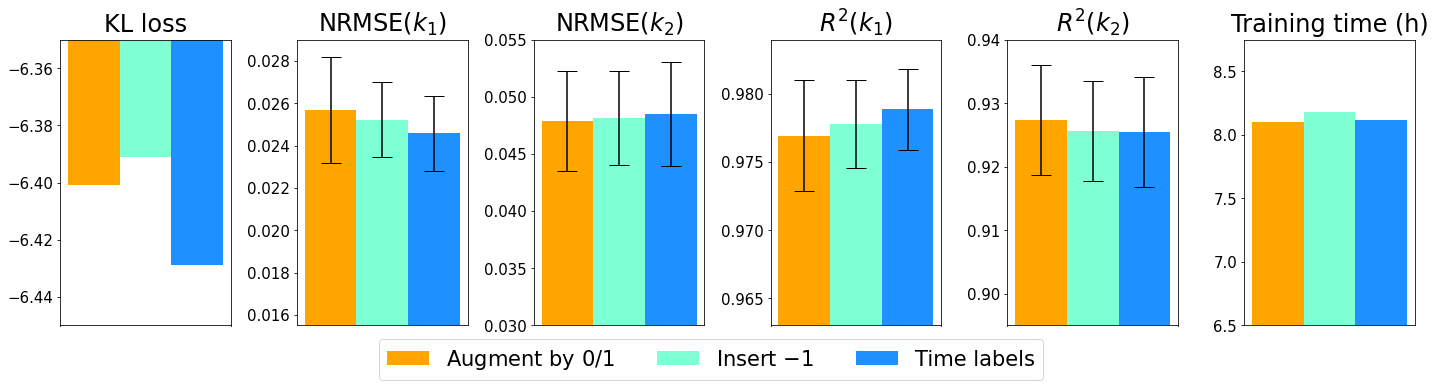

In [30]:
fig, ax = plt.subplots(1, 6, figsize=(20, 5))
plt.rcParams['font.size'] = 15

bar_chart(ax, np.array([-6.401, -6.391, -6.429]), 0, 'KL loss', y_lim=np.array([-6.45, -6.35]))
bar_chart(ax, np.array([a1[0,0], a2[0,0], a3[0,0]]), 1, 'NRMSE$(k_1)$', 
          se=np.array([a1[1,0], a2[1,0], a3[1,0]]), y_lim=np.array([0.0155, 0.029]))
bar_chart(ax, np.array([a1[0,1], a2[0,1], a3[0,1]]), 2, 'NRMSE$(k_2)$', 
          se=np.array([a1[1,1], a2[1,1], a3[1,1]]), y_lim=np.array([0.030, 0.055]))
bar_chart(ax, np.array([a1[0,2], a2[0,2], a3[0,2]]), 3, '$R^2(k_1)$', 
          se=np.array([a1[1,2], a2[1,2], a3[1,2]]), 
          y_lim=np.array([0.963, 0.984]), y_ticks=np.array([0.965, 0.970, 0.975, 0.980]))
bar_chart(ax, np.array([a1[0,3], a2[0,3], a3[0,3]]), 4, '$R^2(k_2)$', 
          se=np.array([a1[1,3], a2[1,3], a3[1,3]]), 
          y_lim=np.array([0.895, 0.94]), y_ticks=np.array([0.90, 0.91, 0.92, 0.93, 0.94]))
bar_chart(ax, np.array([8+6/60, 8+11/60, 8+7/60]), 5, 'Training time (h)', 
          y_lim=np.array([6.5,8.75]), y_ticks=np.array([6.5, 7.0, 7.5, 8.0, 8.5]))

for axes in ax: 
    handles, labels = axes.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.11), ncol=4, fontsize=21)
plt.tight_layout()
plt.show()
fig.savefig("figures/{}_bar_chart.png".format('CR11_missing'), dpi=600, bbox_inches='tight')